In [1]:
# Import
import os
from PIL import Image

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-01-14 15:26:56.119605: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 15:26:56.149087: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-14 15:26:56.149114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-14 15:26:56.149129: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 15:26:56.154847: I tensorflow/core/platform/cpu_feature_g

# Training (Nitrate)

In [2]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/related_nitrate_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*3], ctrl_data[:, 17*3]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [3]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/nitrate/modified/final_model'  # 모델 저장 경로

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*3,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=5,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    
# define callback
def scheduler(epoch, lr):
    if epoch < 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/nitrate/modified/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-01-13 15:19:01.516938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21028 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-01-13 15:19:01.518549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22080 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-01-13 15:19:01.520035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22080 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-01-13 15:19:01.521566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21956 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-01-13 15:19:27.859175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 15:19:27.875044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 15:19:27.905089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 15:19:27.937934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 15:19:30.554380: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f03de25c640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-13 15:19:30.554413: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-13 15:19:30.554417: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-13 15:19:30.55442

3/3 [==============================] - ETA: 0s - loss: 24.5919  INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-01-29.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-01-29.50/assets


3/3 [==============================] - 46s 7s/step - loss: 24.5919 - val_loss: 29.5030 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 20.6565INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-02-29.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-02-29.26/assets


3/3 [==============================] - 9s 4s/step - loss: 20.6565 - val_loss: 29.2603 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - ETA: 0s - loss: 17.3275INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-03-28.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-03-28.93/assets


3/3 [==============================] - 10s 5s/step - loss: 17.3275 - val_loss: 28.9292 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - ETA: 0s - loss: 14.5495INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-04-28.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-04-28.48/assets


3/3 [==============================] - 9s 5s/step - loss: 14.5495 - val_loss: 28.4755 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - ETA: 0s - loss: 12.7669INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-05-27.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-05-27.92/assets


3/3 [==============================] - 9s 5s/step - loss: 12.7669 - val_loss: 27.9158 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - ETA: 0s - loss: 11.7915INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-06-27.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-06-27.29/assets


3/3 [==============================] - 9s 5s/step - loss: 11.7915 - val_loss: 27.2871 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - ETA: 0s - loss: 11.2146INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-07-26.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-07-26.64/assets


3/3 [==============================] - 9s 5s/step - loss: 11.2146 - val_loss: 26.6401 - lr: 0.0010
Epoch 8/500
3/3 [==============================] - ETA: 0s - loss: 10.7880INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-08-26.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-08-26.03/assets


3/3 [==============================] - 9s 5s/step - loss: 10.7880 - val_loss: 26.0266 - lr: 0.0010
Epoch 9/500
3/3 [==============================] - ETA: 0s - loss: 10.4339INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-09-25.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-09-25.47/assets


3/3 [==============================] - 10s 5s/step - loss: 10.4339 - val_loss: 25.4745 - lr: 0.0010
Epoch 10/500
3/3 [==============================] - ETA: 0s - loss: 10.1148INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-10-24.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-10-24.98/assets


3/3 [==============================] - 9s 5s/step - loss: 10.1148 - val_loss: 24.9848 - lr: 0.0010
Epoch 11/500
3/3 [==============================] - ETA: 0s - loss: 9.8265INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-11-24.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-11-24.59/assets


3/3 [==============================] - 9s 5s/step - loss: 9.8265 - val_loss: 24.5893 - lr: 0.0010
Epoch 12/500
3/3 [==============================] - ETA: 0s - loss: 9.5582INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-12-24.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-12-24.26/assets


3/3 [==============================] - 9s 5s/step - loss: 9.5582 - val_loss: 24.2620 - lr: 0.0010
Epoch 13/500
3/3 [==============================] - ETA: 0s - loss: 9.3014INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-13-24.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-13-24.00/assets


3/3 [==============================] - 9s 5s/step - loss: 9.3014 - val_loss: 23.9954 - lr: 0.0010
Epoch 14/500
3/3 [==============================] - ETA: 0s - loss: 9.0575INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-14-23.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-14-23.80/assets


3/3 [==============================] - 9s 5s/step - loss: 9.0575 - val_loss: 23.7954 - lr: 0.0010
Epoch 15/500
3/3 [==============================] - ETA: 0s - loss: 8.8260INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-15-23.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-15-23.66/assets


3/3 [==============================] - 9s 5s/step - loss: 8.8260 - val_loss: 23.6558 - lr: 0.0010
Epoch 16/500
3/3 [==============================] - ETA: 0s - loss: 8.6056INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-16-23.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-16-23.52/assets


3/3 [==============================] - 10s 5s/step - loss: 8.6056 - val_loss: 23.5229 - lr: 0.0010
Epoch 17/500
2/3 [===================>..........] - ETA: 0s - loss: 8.4123INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-17-23.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-17-23.39/assets


3/3 [==============================] - 8s 4s/step - loss: 8.3941 - val_loss: 23.3889 - lr: 0.0010
Epoch 18/500
3/3 [==============================] - ETA: 0s - loss: 8.1846INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-18-23.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-18-23.23/assets


3/3 [==============================] - 11s 5s/step - loss: 8.1846 - val_loss: 23.2295 - lr: 0.0010
Epoch 19/500
2/3 [===================>..........] - ETA: 0s - loss: 7.9789INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-19-23.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-19-23.08/assets


3/3 [==============================] - 9s 5s/step - loss: 7.9819 - val_loss: 23.0813 - lr: 0.0010
Epoch 20/500
3/3 [==============================] - ETA: 0s - loss: 7.7857INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-20-22.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-20-22.96/assets


3/3 [==============================] - 8s 4s/step - loss: 7.7857 - val_loss: 22.9580 - lr: 0.0010
Epoch 21/500
2/3 [===================>..........] - ETA: 0s - loss: 7.6065INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-21-22.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-21-22.80/assets


3/3 [==============================] - 10s 5s/step - loss: 7.5931 - val_loss: 22.8038 - lr: 0.0010
Epoch 22/500
2/3 [===================>..........] - ETA: 0s - loss: 7.4121INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-22-22.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-22-22.65/assets


3/3 [==============================] - 10s 5s/step - loss: 7.4062 - val_loss: 22.6526 - lr: 0.0010
Epoch 23/500
3/3 [==============================] - ETA: 0s - loss: 7.2223INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-23-22.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-23-22.50/assets


3/3 [==============================] - 10s 5s/step - loss: 7.2223 - val_loss: 22.4962 - lr: 0.0010
Epoch 24/500
2/3 [===================>..........] - ETA: 0s - loss: 7.0194INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-24-22.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-24-22.34/assets


3/3 [==============================] - 8s 4s/step - loss: 7.0445 - val_loss: 22.3393 - lr: 0.0010
Epoch 25/500
3/3 [==============================] - ETA: 0s - loss: 6.8691INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-25-22.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-25-22.17/assets


3/3 [==============================] - 10s 5s/step - loss: 6.8691 - val_loss: 22.1693 - lr: 0.0010
Epoch 26/500
3/3 [==============================] - ETA: 0s - loss: 6.7016INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-26-22.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-26-22.02/assets


3/3 [==============================] - 10s 5s/step - loss: 6.7016 - val_loss: 22.0188 - lr: 0.0010
Epoch 27/500
3/3 [==============================] - ETA: 0s - loss: 6.5294INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-27-21.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-27-21.85/assets


3/3 [==============================] - 10s 5s/step - loss: 6.5294 - val_loss: 21.8462 - lr: 0.0010
Epoch 28/500
3/3 [==============================] - ETA: 0s - loss: 6.3662INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-28-21.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-28-21.67/assets


3/3 [==============================] - 10s 5s/step - loss: 6.3662 - val_loss: 21.6722 - lr: 0.0010
Epoch 29/500
3/3 [==============================] - ETA: 0s - loss: 6.2067INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-29-21.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-29-21.47/assets


3/3 [==============================] - 10s 5s/step - loss: 6.2067 - val_loss: 21.4660 - lr: 0.0010
Epoch 30/500
3/3 [==============================] - ETA: 0s - loss: 6.0537INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-30-21.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-30-21.31/assets


3/3 [==============================] - 10s 5s/step - loss: 6.0537 - val_loss: 21.3076 - lr: 0.0010
Epoch 31/500
3/3 [==============================] - ETA: 0s - loss: 5.9030INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-31-21.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-31-21.13/assets


3/3 [==============================] - 10s 5s/step - loss: 5.9030 - val_loss: 21.1306 - lr: 0.0010
Epoch 32/500
3/3 [==============================] - ETA: 0s - loss: 5.7504INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-32-20.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-32-20.98/assets


3/3 [==============================] - 10s 5s/step - loss: 5.7504 - val_loss: 20.9832 - lr: 0.0010
Epoch 33/500
3/3 [==============================] - ETA: 0s - loss: 5.6047INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-33-20.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-33-20.79/assets


3/3 [==============================] - 10s 5s/step - loss: 5.6047 - val_loss: 20.7881 - lr: 0.0010
Epoch 34/500
3/3 [==============================] - ETA: 0s - loss: 5.4630INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-34-20.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-34-20.59/assets


3/3 [==============================] - 8s 4s/step - loss: 5.4630 - val_loss: 20.5921 - lr: 0.0010
Epoch 35/500
2/3 [===================>..........] - ETA: 0s - loss: 5.3355INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-35-20.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-35-20.33/assets


3/3 [==============================] - 10s 5s/step - loss: 5.3248 - val_loss: 20.3334 - lr: 0.0010
Epoch 36/500
3/3 [==============================] - ETA: 0s - loss: 5.1913INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-36-20.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-36-20.14/assets


3/3 [==============================] - 10s 5s/step - loss: 5.1913 - val_loss: 20.1354 - lr: 0.0010
Epoch 37/500
3/3 [==============================] - ETA: 0s - loss: 5.0572INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-37-19.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-37-19.90/assets


3/3 [==============================] - 10s 5s/step - loss: 5.0572 - val_loss: 19.8992 - lr: 0.0010
Epoch 38/500
3/3 [==============================] - ETA: 0s - loss: 4.9276INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-38-19.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-38-19.69/assets


3/3 [==============================] - 10s 5s/step - loss: 4.9276 - val_loss: 19.6853 - lr: 0.0010
Epoch 39/500
3/3 [==============================] - ETA: 0s - loss: 4.8023INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-39-19.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-39-19.48/assets


3/3 [==============================] - 8s 4s/step - loss: 4.8023 - val_loss: 19.4843 - lr: 0.0010
Epoch 40/500
3/3 [==============================] - ETA: 0s - loss: 4.6779INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-40-19.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-40-19.33/assets


3/3 [==============================] - 10s 5s/step - loss: 4.6779 - val_loss: 19.3273 - lr: 0.0010
Epoch 41/500
3/3 [==============================] - ETA: 0s - loss: 4.5560INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-41-19.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-41-19.09/assets


3/3 [==============================] - 10s 5s/step - loss: 4.5560 - val_loss: 19.0858 - lr: 0.0010
Epoch 42/500
3/3 [==============================] - ETA: 0s - loss: 4.4365INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-42-18.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-42-18.91/assets


3/3 [==============================] - 10s 5s/step - loss: 4.4365 - val_loss: 18.9120 - lr: 0.0010
Epoch 43/500
3/3 [==============================] - ETA: 0s - loss: 4.3207INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-43-18.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-43-18.66/assets


3/3 [==============================] - 8s 4s/step - loss: 4.3207 - val_loss: 18.6550 - lr: 0.0010
Epoch 44/500
3/3 [==============================] - ETA: 0s - loss: 4.2085INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-44-18.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-44-18.51/assets


3/3 [==============================] - 10s 5s/step - loss: 4.2085 - val_loss: 18.5064 - lr: 0.0010
Epoch 45/500
3/3 [==============================] - ETA: 0s - loss: 4.0974INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-45-18.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-45-18.31/assets


3/3 [==============================] - 10s 5s/step - loss: 4.0974 - val_loss: 18.3117 - lr: 0.0010
Epoch 46/500
2/3 [===================>..........] - ETA: 0s - loss: 3.9887INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-46-18.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-46-18.07/assets


3/3 [==============================] - 10s 5s/step - loss: 3.9855 - val_loss: 18.0745 - lr: 0.0010
Epoch 47/500
2/3 [===================>..........] - ETA: 0s - loss: 3.9036INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-47-17.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-47-17.89/assets


3/3 [==============================] - 8s 4s/step - loss: 3.8774 - val_loss: 17.8850 - lr: 0.0010
Epoch 48/500
3/3 [==============================] - ETA: 0s - loss: 3.7703INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-48-17.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-48-17.69/assets


3/3 [==============================] - 10s 5s/step - loss: 3.7703 - val_loss: 17.6907 - lr: 0.0010
Epoch 49/500
3/3 [==============================] - ETA: 0s - loss: 3.6682INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-49-17.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-49-17.45/assets


3/3 [==============================] - 10s 5s/step - loss: 3.6682 - val_loss: 17.4521 - lr: 0.0010
Epoch 50/500
3/3 [==============================] - ETA: 0s - loss: 3.5692INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-50-17.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-50-17.32/assets


3/3 [==============================] - 8s 4s/step - loss: 3.5692 - val_loss: 17.3220 - lr: 0.0010
Epoch 51/500
3/3 [==============================] - ETA: 0s - loss: 3.4697INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-51-17.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-51-17.08/assets


3/3 [==============================] - 10s 5s/step - loss: 3.4697 - val_loss: 17.0778 - lr: 0.0010
Epoch 52/500
3/3 [==============================] - ETA: 0s - loss: 3.3676INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-52-16.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-52-16.98/assets


3/3 [==============================] - 10s 5s/step - loss: 3.3676 - val_loss: 16.9804 - lr: 0.0010
Epoch 53/500
3/3 [==============================] - ETA: 0s - loss: 3.2728INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-53-16.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-53-16.79/assets


3/3 [==============================] - 8s 4s/step - loss: 3.2728 - val_loss: 16.7944 - lr: 0.0010
Epoch 54/500
3/3 [==============================] - ETA: 0s - loss: 3.1773INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-54-16.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-54-16.66/assets


3/3 [==============================] - 10s 5s/step - loss: 3.1773 - val_loss: 16.6634 - lr: 0.0010
Epoch 55/500
3/3 [==============================] - ETA: 0s - loss: 3.0866INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-55-16.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-55-16.47/assets


3/3 [==============================] - 10s 5s/step - loss: 3.0866 - val_loss: 16.4697 - lr: 0.0010
Epoch 56/500
2/3 [===================>..........] - ETA: 0s - loss: 3.0147INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-56-16.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-56-16.17/assets


3/3 [==============================] - 10s 5s/step - loss: 2.9998 - val_loss: 16.1737 - lr: 0.0010
Epoch 57/500
3/3 [==============================] - ETA: 0s - loss: 2.9106INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-57-15.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-57-15.94/assets


3/3 [==============================] - 8s 4s/step - loss: 2.9106 - val_loss: 15.9388 - lr: 0.0010
Epoch 58/500
3/3 [==============================] - ETA: 0s - loss: 2.8295INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-58-15.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-58-15.70/assets


3/3 [==============================] - 10s 5s/step - loss: 2.8295 - val_loss: 15.6968 - lr: 0.0010
Epoch 59/500
2/3 [===================>..........] - ETA: 0s - loss: 2.7423INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-59-15.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-59-15.54/assets


3/3 [==============================] - 10s 5s/step - loss: 2.7478 - val_loss: 15.5354 - lr: 0.0010
Epoch 60/500
3/3 [==============================] - ETA: 0s - loss: 2.6675INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-60-15.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-60-15.23/assets


3/3 [==============================] - 8s 4s/step - loss: 2.6675 - val_loss: 15.2291 - lr: 0.0010
Epoch 61/500
3/3 [==============================] - ETA: 0s - loss: 2.5900INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-61-15.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-61-15.09/assets


3/3 [==============================] - 11s 5s/step - loss: 2.5900 - val_loss: 15.0929 - lr: 0.0010
Epoch 62/500
3/3 [==============================] - ETA: 0s - loss: 2.5149INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-62-14.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-62-14.75/assets


3/3 [==============================] - 8s 4s/step - loss: 2.5149 - val_loss: 14.7475 - lr: 0.0010
Epoch 63/500
2/3 [===================>..........] - ETA: 0s - loss: 2.4528INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-63-14.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-63-14.61/assets


3/3 [==============================] - 10s 5s/step - loss: 2.4409 - val_loss: 14.6145 - lr: 0.0010
Epoch 64/500
3/3 [==============================] - ETA: 0s - loss: 2.3683INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-64-14.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-64-14.38/assets


3/3 [==============================] - 10s 5s/step - loss: 2.3683 - val_loss: 14.3761 - lr: 0.0010
Epoch 65/500
3/3 [==============================] - ETA: 0s - loss: 2.2977INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-65-14.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-65-14.07/assets


3/3 [==============================] - 9s 4s/step - loss: 2.2977 - val_loss: 14.0691 - lr: 0.0010
Epoch 66/500
3/3 [==============================] - ETA: 0s - loss: 2.2301INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-66-13.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-66-13.93/assets


3/3 [==============================] - 11s 5s/step - loss: 2.2301 - val_loss: 13.9278 - lr: 0.0010
Epoch 67/500
3/3 [==============================] - ETA: 0s - loss: 2.1636INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-67-13.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-67-13.73/assets


3/3 [==============================] - 10s 5s/step - loss: 2.1636 - val_loss: 13.7283 - lr: 0.0010
Epoch 68/500
3/3 [==============================] - ETA: 0s - loss: 2.0991INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-68-13.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-68-13.50/assets


3/3 [==============================] - 8s 4s/step - loss: 2.0991 - val_loss: 13.4962 - lr: 0.0010
Epoch 69/500
3/3 [==============================] - ETA: 0s - loss: 2.0399INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-69-13.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-69-13.24/assets


3/3 [==============================] - 11s 5s/step - loss: 2.0399 - val_loss: 13.2434 - lr: 0.0010
Epoch 70/500
2/3 [===================>..........] - ETA: 0s - loss: 1.9687INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-70-12.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-70-12.94/assets


3/3 [==============================] - 8s 4s/step - loss: 1.9782 - val_loss: 12.9363 - lr: 0.0010
Epoch 71/500
3/3 [==============================] - ETA: 0s - loss: 1.9223INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-71-12.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-71-12.66/assets


3/3 [==============================] - 11s 5s/step - loss: 1.9223 - val_loss: 12.6562 - lr: 0.0010
Epoch 72/500
2/3 [===================>..........] - ETA: 0s - loss: 1.8701INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-72-12.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-72-12.49/assets


3/3 [==============================] - 10s 5s/step - loss: 1.8633 - val_loss: 12.4886 - lr: 0.0010
Epoch 73/500
3/3 [==============================] - ETA: 0s - loss: 1.8057INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-73-12.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-73-12.45/assets


3/3 [==============================] - 9s 4s/step - loss: 1.8057 - val_loss: 12.4465 - lr: 0.0010
Epoch 74/500
3/3 [==============================] - ETA: 0s - loss: 1.7537INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-74-12.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-74-12.08/assets


3/3 [==============================] - 11s 5s/step - loss: 1.7537 - val_loss: 12.0809 - lr: 0.0010
Epoch 75/500
3/3 [==============================] - ETA: 0s - loss: 1.7013INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-75-11.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-75-11.89/assets


3/3 [==============================] - 8s 4s/step - loss: 1.7013 - val_loss: 11.8856 - lr: 0.0010
Epoch 76/500
2/3 [===================>..........] - ETA: 0s - loss: 1.6425INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-76-11.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-76-11.64/assets


3/3 [==============================] - 11s 5s/step - loss: 1.6525 - val_loss: 11.6373 - lr: 0.0010
Epoch 77/500
3/3 [==============================] - ETA: 0s - loss: 1.5967INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-77-11.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-77-11.37/assets


3/3 [==============================] - 10s 5s/step - loss: 1.5967 - val_loss: 11.3745 - lr: 0.0010
Epoch 78/500
3/3 [==============================] - ETA: 0s - loss: 1.5486INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-78-11.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-78-11.24/assets


3/3 [==============================] - 9s 4s/step - loss: 1.5486 - val_loss: 11.2355 - lr: 0.0010
Epoch 79/500
3/3 [==============================] - ETA: 0s - loss: 1.5026INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-79-11.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-79-11.20/assets


3/3 [==============================] - 11s 5s/step - loss: 1.5026 - val_loss: 11.2024 - lr: 0.0010
Epoch 80/500
3/3 [==============================] - ETA: 0s - loss: 1.4614INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-80-10.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-80-10.87/assets


3/3 [==============================] - 9s 4s/step - loss: 1.4614 - val_loss: 10.8685 - lr: 0.0010
Epoch 81/500
3/3 [==============================] - ETA: 0s - loss: 1.4150INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-81-10.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-81-10.68/assets


3/3 [==============================] - 11s 5s/step - loss: 1.4150 - val_loss: 10.6837 - lr: 0.0010
Epoch 82/500
3/3 [==============================] - ETA: 0s - loss: 1.3728INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-82-10.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-82-10.42/assets


3/3 [==============================] - 9s 4s/step - loss: 1.3728 - val_loss: 10.4230 - lr: 0.0010
Epoch 83/500
3/3 [==============================] - ETA: 0s - loss: 1.3315INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-83-10.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-83-10.07/assets


3/3 [==============================] - 11s 5s/step - loss: 1.3315 - val_loss: 10.0698 - lr: 0.0010
Epoch 84/500
3/3 [==============================] - ETA: 0s - loss: 1.2898INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-84-9.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-84-9.89/assets


3/3 [==============================] - 9s 4s/step - loss: 1.2898 - val_loss: 9.8871 - lr: 0.0010
Epoch 85/500
3/3 [==============================] - ETA: 0s - loss: 1.2496INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-85-9.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-85-9.63/assets


3/3 [==============================] - 11s 5s/step - loss: 1.2496 - val_loss: 9.6269 - lr: 0.0010
Epoch 86/500
3/3 [==============================] - ETA: 0s - loss: 1.2154INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-86-9.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-86-9.40/assets


3/3 [==============================] - 11s 5s/step - loss: 1.2154 - val_loss: 9.4025 - lr: 0.0010
Epoch 87/500
3/3 [==============================] - ETA: 0s - loss: 1.1790INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-87-9.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-87-9.34/assets


3/3 [==============================] - 8s 4s/step - loss: 1.1790 - val_loss: 9.3443 - lr: 0.0010
Epoch 88/500
3/3 [==============================] - ETA: 0s - loss: 1.1378INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-88-9.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-88-9.13/assets


3/3 [==============================] - 11s 5s/step - loss: 1.1378 - val_loss: 9.1282 - lr: 0.0010
Epoch 89/500
3/3 [==============================] - ETA: 0s - loss: 1.1018INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-89-8.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-89-8.79/assets


3/3 [==============================] - 9s 4s/step - loss: 1.1018 - val_loss: 8.7903 - lr: 0.0010
Epoch 90/500
3/3 [==============================] - ETA: 0s - loss: 1.0659INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-90-8.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-90-8.64/assets


3/3 [==============================] - 11s 5s/step - loss: 1.0659 - val_loss: 8.6360 - lr: 0.0010
Epoch 91/500
2/3 [===================>..........] - ETA: 0s - loss: 1.0387INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-91-8.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-91-8.60/assets


3/3 [==============================] - 9s 4s/step - loss: 1.0321 - val_loss: 8.6018 - lr: 0.0010
Epoch 92/500
3/3 [==============================] - ETA: 0s - loss: 1.0004INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-92-8.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-92-8.43/assets


3/3 [==============================] - 11s 5s/step - loss: 1.0004 - val_loss: 8.4264 - lr: 0.0010
Epoch 93/500
3/3 [==============================] - ETA: 0s - loss: 0.9701INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-93-8.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-93-8.21/assets


3/3 [==============================] - 8s 4s/step - loss: 0.9701 - val_loss: 8.2075 - lr: 0.0010
Epoch 94/500
3/3 [==============================] - ETA: 0s - loss: 0.9419INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-94-8.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-94-8.06/assets


3/3 [==============================] - 11s 5s/step - loss: 0.9419 - val_loss: 8.0643 - lr: 0.0010
Epoch 95/500
3/3 [==============================] - ETA: 0s - loss: 0.9086INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-95-7.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-95-7.79/assets


3/3 [==============================] - 8s 4s/step - loss: 0.9086 - val_loss: 7.7924 - lr: 0.0010
Epoch 96/500
2/3 [===================>..........] - ETA: 0s - loss: 0.8807INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-96-7.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-96-7.53/assets


3/3 [==============================] - 8s 4s/step - loss: 0.8802 - val_loss: 7.5264 - lr: 0.0010
Epoch 97/500
2/3 [===================>..........] - ETA: 0s - loss: 0.8511INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-97-7.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-97-7.38/assets


3/3 [==============================] - 11s 6s/step - loss: 0.8532 - val_loss: 7.3755 - lr: 0.0010
Epoch 98/500
3/3 [==============================] - ETA: 0s - loss: 0.8258INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-98-7.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-98-7.22/assets


3/3 [==============================] - 11s 5s/step - loss: 0.8258 - val_loss: 7.2174 - lr: 0.0010
Epoch 99/500
3/3 [==============================] - ETA: 0s - loss: 0.7999INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-99-7.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-99-7.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.7999 - val_loss: 7.0325 - lr: 0.0010
Epoch 100/500
3/3 [==============================] - ETA: 0s - loss: 0.7761INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-100-6.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-100-6.70/assets


3/3 [==============================] - 8s 4s/step - loss: 0.7761 - val_loss: 6.7044 - lr: 0.0010
Epoch 101/500
2/3 [===================>..........] - ETA: 0s - loss: 0.7555INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-101-6.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-101-6.54/assets


3/3 [==============================] - 11s 6s/step - loss: 0.7519 - val_loss: 6.5360 - lr: 0.0010
Epoch 102/500
2/3 [===================>..........] - ETA: 0s - loss: 0.7188INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-102-6.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-102-6.44/assets


3/3 [==============================] - 8s 4s/step - loss: 0.7251 - val_loss: 6.4390 - lr: 0.0010
Epoch 103/500
3/3 [==============================] - ETA: 0s - loss: 0.7019INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-103-6.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-103-6.32/assets


3/3 [==============================] - 11s 6s/step - loss: 0.7019 - val_loss: 6.3158 - lr: 0.0010
Epoch 104/500
3/3 [==============================] - ETA: 0s - loss: 0.6797INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-104-6.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-104-6.23/assets


3/3 [==============================] - 11s 5s/step - loss: 0.6797 - val_loss: 6.2335 - lr: 0.0010
Epoch 105/500
2/3 [===================>..........] - ETA: 0s - loss: 0.6565INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-105-6.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-105-6.01/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6582 - val_loss: 6.0091 - lr: 0.0010
Epoch 106/500
3/3 [==============================] - ETA: 0s - loss: 0.6403INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-106-5.97/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-106-5.97/assets


3/3 [==============================] - 8s 4s/step - loss: 0.6403 - val_loss: 5.9729 - lr: 0.0010
Epoch 107/500
3/3 [==============================] - ETA: 0s - loss: 0.6206INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-107-5.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-107-5.82/assets


3/3 [==============================] - 11s 6s/step - loss: 0.6206 - val_loss: 5.8156 - lr: 0.0010
Epoch 108/500
3/3 [==============================] - ETA: 0s - loss: 0.6006INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-108-5.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-108-5.46/assets


3/3 [==============================] - 8s 4s/step - loss: 0.6006 - val_loss: 5.4610 - lr: 0.0010
Epoch 109/500
3/3 [==============================] - ETA: 0s - loss: 0.5862INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-109-5.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-109-5.19/assets


3/3 [==============================] - 11s 6s/step - loss: 0.5862 - val_loss: 5.1925 - lr: 0.0010
Epoch 110/500
3/3 [==============================] - ETA: 0s - loss: 0.5649INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-110-5.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-110-5.04/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5649 - val_loss: 5.0384 - lr: 0.0010
Epoch 111/500
3/3 [==============================] - ETA: 0s - loss: 0.5444INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-111-4.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-111-4.90/assets


3/3 [==============================] - 11s 6s/step - loss: 0.5444 - val_loss: 4.9021 - lr: 0.0010
Epoch 112/500
3/3 [==============================] - ETA: 0s - loss: 0.5267INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-112-4.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-112-4.71/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5267 - val_loss: 4.7117 - lr: 0.0010
Epoch 113/500
3/3 [==============================] - ETA: 0s - loss: 0.5089INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-113-4.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-113-4.71/assets


3/3 [==============================] - 11s 6s/step - loss: 0.5089 - val_loss: 4.7073 - lr: 0.0010
Epoch 114/500
3/3 [==============================] - ETA: 0s - loss: 0.4932INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-114-4.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-114-4.63/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4932 - val_loss: 4.6327 - lr: 0.0010
Epoch 115/500
3/3 [==============================] - ETA: 0s - loss: 0.4743INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-115-4.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-115-4.62/assets


3/3 [==============================] - 11s 6s/step - loss: 0.4743 - val_loss: 4.6212 - lr: 0.0010
Epoch 116/500
3/3 [==============================] - ETA: 0s - loss: 0.4616INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-116-4.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-116-4.40/assets


3/3 [==============================] - 8s 4s/step - loss: 0.4616 - val_loss: 4.4018 - lr: 0.0010
Epoch 117/500
3/3 [==============================] - ETA: 0s - loss: 0.4431INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-117-4.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-117-4.34/assets


3/3 [==============================] - 11s 6s/step - loss: 0.4431 - val_loss: 4.3416 - lr: 0.0010
Epoch 118/500
3/3 [==============================] - ETA: 0s - loss: 0.4288INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-118-4.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-118-4.34/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4288 - val_loss: 4.3403 - lr: 0.0010
Epoch 119/500
3/3 [==============================] - ETA: 0s - loss: 0.4157INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-119-4.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-119-4.06/assets


3/3 [==============================] - 8s 4s/step - loss: 0.4157 - val_loss: 4.0622 - lr: 0.0010
Epoch 120/500
3/3 [==============================] - ETA: 0s - loss: 0.4021INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-120-3.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-120-3.95/assets


3/3 [==============================] - 12s 6s/step - loss: 0.4021 - val_loss: 3.9516 - lr: 0.0010
Epoch 121/500
3/3 [==============================] - ETA: 0s - loss: 0.3881INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-121-3.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-121-3.85/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3881 - val_loss: 3.8466 - lr: 0.0010
Epoch 122/500
3/3 [==============================] - ETA: 0s - loss: 0.3759INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-122-3.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-122-3.81/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3759 - val_loss: 3.8147 - lr: 0.0010
Epoch 123/500
3/3 [==============================] - ETA: 0s - loss: 0.3647INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-123-3.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-123-3.64/assets


3/3 [==============================] - 8s 4s/step - loss: 0.3647 - val_loss: 3.6442 - lr: 0.0010
Epoch 124/500
3/3 [==============================] - ETA: 0s - loss: 0.3518INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-124-3.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-124-3.51/assets


3/3 [==============================] - 11s 6s/step - loss: 0.3518 - val_loss: 3.5089 - lr: 0.0010
Epoch 125/500
3/3 [==============================] - ETA: 0s - loss: 0.3416INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-125-3.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-125-3.34/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3416 - val_loss: 3.3409 - lr: 0.0010
Epoch 126/500
3/3 [==============================] - ETA: 0s - loss: 0.3295INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-126-3.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-126-3.20/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3295 - val_loss: 3.1969 - lr: 0.0010
Epoch 127/500
3/3 [==============================] - ETA: 0s - loss: 0.3216INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-127-3.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-127-3.05/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3216 - val_loss: 3.0524 - lr: 0.0010
Epoch 128/500
3/3 [==============================] - ETA: 0s - loss: 0.3105INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-128-3.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-128-3.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3105 - val_loss: 3.0417 - lr: 0.0010
Epoch 129/500
2/3 [===================>..........] - ETA: 0s - loss: 0.3031INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-129-2.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-129-2.88/assets


3/3 [==============================] - 11s 6s/step - loss: 0.3022 - val_loss: 2.8839 - lr: 0.0010
Epoch 130/500
3/3 [==============================] - ETA: 0s - loss: 0.2926INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-130-2.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-130-2.73/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2926 - val_loss: 2.7338 - lr: 0.0010
Epoch 131/500
3/3 [==============================] - ETA: 0s - loss: 0.2839INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-131-2.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-131-2.70/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2839 - val_loss: 2.7037 - lr: 0.0010
Epoch 132/500
2/3 [===================>..........] - ETA: 0s - loss: 0.2734INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-132-2.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-132-2.59/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2759 - val_loss: 2.5935 - lr: 0.0010
Epoch 133/500
3/3 [==============================] - ETA: 0s - loss: 0.2670INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-133-2.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-133-2.48/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2670 - val_loss: 2.4841 - lr: 0.0010
Epoch 134/500
3/3 [==============================] - ETA: 0s - loss: 0.2583INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-134-2.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-134-2.43/assets


3/3 [==============================] - 13s 6s/step - loss: 0.2583 - val_loss: 2.4349 - lr: 0.0010
Epoch 135/500
3/3 [==============================] - ETA: 0s - loss: 0.2494INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-135-2.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-135-2.36/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2494 - val_loss: 2.3613 - lr: 0.0010
Epoch 136/500
3/3 [==============================] - ETA: 0s - loss: 0.2422INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-136-2.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-136-2.34/assets


3/3 [==============================] - 8s 4s/step - loss: 0.2422 - val_loss: 2.3418 - lr: 0.0010
Epoch 137/500
3/3 [==============================] - ETA: 0s - loss: 0.2338INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-137-2.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-137-2.21/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2338 - val_loss: 2.2104 - lr: 0.0010
Epoch 138/500
3/3 [==============================] - ETA: 0s - loss: 0.2276INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-138-2.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-138-2.15/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2276 - val_loss: 2.1463 - lr: 0.0010
Epoch 139/500
3/3 [==============================] - ETA: 0s - loss: 0.2221INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-139-2.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-139-2.08/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2221 - val_loss: 2.0771 - lr: 0.0010
Epoch 140/500
3/3 [==============================] - ETA: 0s - loss: 0.2146INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-140-1.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-140-1.91/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2146 - val_loss: 1.9129 - lr: 0.0010
Epoch 141/500
3/3 [==============================] - 0s 213ms/step - loss: 0.2092 - val_loss: 1.9413 - lr: 0.0010
Epoch 142/500
2/3 [===================>..........] - ETA: 0s - loss: 0.2038INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-142-1.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-142-1.79/assets


3/3 [==============================] - 8s 4s/step - loss: 0.2033 - val_loss: 1.7946 - lr: 0.0010
Epoch 143/500
3/3 [==============================] - ETA: 0s - loss: 0.1984INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-143-1.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-143-1.71/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1984 - val_loss: 1.7074 - lr: 0.0010
Epoch 144/500
3/3 [==============================] - ETA: 0s - loss: 0.1914INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-144-1.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-144-1.58/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1914 - val_loss: 1.5761 - lr: 0.0010
Epoch 145/500
3/3 [==============================] - ETA: 0s - loss: 0.1865INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-145-1.56/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-145-1.56/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1865 - val_loss: 1.5560 - lr: 0.0010
Epoch 146/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1805INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-146-1.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-146-1.50/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1809 - val_loss: 1.4961 - lr: 0.0010
Epoch 147/500
3/3 [==============================] - 0s 216ms/step - loss: 0.1764 - val_loss: 1.5475 - lr: 0.0010
Epoch 148/500
3/3 [==============================] - ETA: 0s - loss: 0.1718INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-148-1.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-148-1.47/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1718 - val_loss: 1.4700 - lr: 0.0010
Epoch 149/500
3/3 [==============================] - ETA: 0s - loss: 0.1663INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-149-1.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-149-1.44/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1663 - val_loss: 1.4413 - lr: 0.0010
Epoch 150/500
3/3 [==============================] - ETA: 0s - loss: 0.1648INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-150-1.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-150-1.33/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1648 - val_loss: 1.3340 - lr: 0.0010
Epoch 151/500
3/3 [==============================] - ETA: 0s - loss: 0.1599INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-151-1.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-151-1.31/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1599 - val_loss: 1.3108 - lr: 0.0010
Epoch 152/500
3/3 [==============================] - ETA: 0s - loss: 0.1595INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-152-1.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-152-1.22/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1595 - val_loss: 1.2239 - lr: 0.0010
Epoch 153/500
3/3 [==============================] - 0s 205ms/step - loss: 0.1533 - val_loss: 1.2255 - lr: 0.0010
Epoch 154/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1515INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-154-1.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-154-1.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1521 - val_loss: 1.0302 - lr: 0.0010
Epoch 155/500
3/3 [==============================] - ETA: 0s - loss: 0.1470INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-155-1.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-155-1.02/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1470 - val_loss: 1.0218 - lr: 0.0010
Epoch 156/500
3/3 [==============================] - ETA: 0s - loss: 0.1436INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-156-1.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-156-1.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1436 - val_loss: 1.0152 - lr: 0.0010
Epoch 157/500
3/3 [==============================] - 0s 215ms/step - loss: 0.1391 - val_loss: 1.0841 - lr: 0.0010
Epoch 158/500
3/3 [==============================] - 1s 232ms/step - loss: 0.1373 - val_loss: 1.0383 - lr: 0.0010
Epoch 159/500
3/3 [==============================] - ETA: 0s - loss: 0.1337INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-159-0.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-159-0.96/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1337 - val_loss: 0.9618 - lr: 0.0010
Epoch 160/500
3/3 [==============================] - ETA: 0s - loss: 0.1302INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-160-0.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-160-0.87/assets


3/3 [==============================] - 13s 6s/step - loss: 0.1302 - val_loss: 0.8704 - lr: 0.0010
Epoch 161/500
3/3 [==============================] - 0s 205ms/step - loss: 0.1270 - val_loss: 0.9191 - lr: 0.0010
Epoch 162/500
3/3 [==============================] - ETA: 0s - loss: 0.1258INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-162-0.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-162-0.81/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1258 - val_loss: 0.8126 - lr: 0.0010
Epoch 163/500
3/3 [==============================] - ETA: 0s - loss: 0.1218INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-163-0.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-163-0.77/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1218 - val_loss: 0.7678 - lr: 0.0010
Epoch 164/500
3/3 [==============================] - 0s 201ms/step - loss: 0.1206 - val_loss: 0.7870 - lr: 0.0010
Epoch 165/500
3/3 [==============================] - 0s 214ms/step - loss: 0.1194 - val_loss: 0.8042 - lr: 0.0010
Epoch 166/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1163INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-166-0.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-166-0.66/assets


3/3 [==============================] - 13s 6s/step - loss: 0.1192 - val_loss: 0.6642 - lr: 0.0010
Epoch 167/500
3/3 [==============================] - ETA: 0s - loss: 0.1157INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-167-0.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-167-0.65/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1157 - val_loss: 0.6512 - lr: 0.0010
Epoch 168/500
3/3 [==============================] - ETA: 0s - loss: 0.1135INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-168-0.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-168-0.60/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1135 - val_loss: 0.6033 - lr: 0.0010
Epoch 169/500
3/3 [==============================] - ETA: 0s - loss: 0.1115INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-169-0.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-169-0.55/assets


3/3 [==============================] - 13s 6s/step - loss: 0.1115 - val_loss: 0.5492 - lr: 0.0010
Epoch 170/500
3/3 [==============================] - 0s 225ms/step - loss: 0.1115 - val_loss: 0.5542 - lr: 0.0010
Epoch 171/500
3/3 [==============================] - ETA: 0s - loss: 0.1083INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-171-0.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-171-0.54/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1083 - val_loss: 0.5395 - lr: 0.0010
Epoch 172/500
3/3 [==============================] - 0s 208ms/step - loss: 0.1075 - val_loss: 0.6227 - lr: 0.0010
Epoch 173/500
3/3 [==============================] - 0s 182ms/step - loss: 0.1094 - val_loss: 0.5775 - lr: 0.0010
Epoch 174/500
3/3 [==============================] - ETA: 0s - loss: 0.1055INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-174-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-174-0.53/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1055 - val_loss: 0.5307 - lr: 0.0010
Epoch 175/500
3/3 [==============================] - ETA: 0s - loss: 0.1025INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-175-0.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-175-0.49/assets


3/3 [==============================] - 13s 6s/step - loss: 0.1025 - val_loss: 0.4890 - lr: 0.0010
Epoch 176/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1027INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-176-0.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-176-0.46/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1030 - val_loss: 0.4587 - lr: 0.0010
Epoch 177/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1000INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-177-0.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-177-0.35/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1010 - val_loss: 0.3509 - lr: 0.0010
Epoch 178/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0998 - val_loss: 0.4516 - lr: 0.0010
Epoch 179/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0997 - val_loss: 0.4894 - lr: 0.0010
Epoch 180/500
3/3 [==============================] - 0s 218ms/step - loss: 0.1003 - val_loss: 0.3806 - lr: 0.0010
Epoch 181/500
3/3 [==============================] - 1s 236ms/step - loss: 0.0965 - val_loss: 0.4129 - lr: 0.0010
Epoch 182/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0946 - val_loss: 0.4361 - lr: 0.0010
Epoch 183/500
3/3 [==============================] - 0s 226ms/step - loss: 0.0944 - val_loss: 0.4321 - lr: 0.0010
Epoch 184/500
3/3 [==============================] - 1s 234ms/step - loss: 0.0933 - val_loss: 0.4357 - lr: 0.0010
Epoch 185/500
3/3 [==============================] - ETA: 0s - loss: 0.0929INFO:tensorflow:Assets writte

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-185-0.32/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0929 - val_loss: 0.3190 - lr: 0.0010
Epoch 186/500
3/3 [==============================] - 1s 231ms/step - loss: 0.0916 - val_loss: 0.3219 - lr: 0.0010
Epoch 187/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0913 - val_loss: 0.3667 - lr: 0.0010
Epoch 188/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0896 - val_loss: 0.3803 - lr: 0.0010
Epoch 189/500
3/3 [==============================] - 0s 184ms/step - loss: 0.0893 - val_loss: 0.3675 - lr: 0.0010
Epoch 190/500
3/3 [==============================] - ETA: 0s - loss: 0.0895INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-190-0.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-190-0.31/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0895 - val_loss: 0.3063 - lr: 0.0010
Epoch 191/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0867 - val_loss: 0.3114 - lr: 0.0010
Epoch 192/500
3/3 [==============================] - 1s 229ms/step - loss: 0.0870 - val_loss: 0.3134 - lr: 0.0010
Epoch 193/500
3/3 [==============================] - ETA: 0s - loss: 0.0867INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-193-0.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-193-0.30/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0867 - val_loss: 0.3025 - lr: 0.0010
Epoch 194/500
3/3 [==============================] - ETA: 0s - loss: 0.0857INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-194-0.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-194-0.25/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0857 - val_loss: 0.2468 - lr: 0.0010
Epoch 195/500
3/3 [==============================] - 1s 234ms/step - loss: 0.0844 - val_loss: 0.2528 - lr: 0.0010
Epoch 196/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0857 - val_loss: 0.2600 - lr: 0.0010
Epoch 197/500
3/3 [==============================] - ETA: 0s - loss: 0.0856INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-197-0.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-197-0.22/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0856 - val_loss: 0.2236 - lr: 0.0010
Epoch 198/500
3/3 [==============================] - 0s 215ms/step - loss: 0.0862 - val_loss: 0.2376 - lr: 0.0010
Epoch 199/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0851 - val_loss: 0.2273 - lr: 0.0010
Epoch 200/500
3/3 [==============================] - ETA: 0s - loss: 0.0841INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-200-0.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-200-0.22/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0841 - val_loss: 0.2235 - lr: 0.0010
Epoch 201/500
3/3 [==============================] - 0s 224ms/step - loss: 0.0828 - val_loss: 0.2307 - lr: 0.0010
Epoch 202/500
3/3 [==============================] - ETA: 0s - loss: 0.0830INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-202-0.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-202-0.22/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0830 - val_loss: 0.2158 - lr: 0.0010
Epoch 203/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0827 - val_loss: 0.2245 - lr: 0.0010
Epoch 204/500
3/3 [==============================] - ETA: 0s - loss: 0.0839INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-204-0.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-204-0.20/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0839 - val_loss: 0.2020 - lr: 0.0010
Epoch 205/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0815INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-205-0.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-205-0.17/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0817 - val_loss: 0.1722 - lr: 0.0010
Epoch 206/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0812INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-206-0.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-206-0.17/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0815 - val_loss: 0.1651 - lr: 0.0010
Epoch 207/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0816 - val_loss: 0.1674 - lr: 0.0010
Epoch 208/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0811 - val_loss: 0.1682 - lr: 0.0010
Epoch 209/500
3/3 [==============================] - ETA: 0s - loss: 0.0806INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-209-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-209-0.15/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0806 - val_loss: 0.1505 - lr: 0.0010
Epoch 210/500
3/3 [==============================] - ETA: 0s - loss: 0.0809INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-210-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-210-0.15/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0809 - val_loss: 0.1452 - lr: 0.0010
Epoch 211/500
3/3 [==============================] - 0s 186ms/step - loss: 0.0808 - val_loss: 0.1766 - lr: 0.0010
Epoch 212/500
3/3 [==============================] - 0s 215ms/step - loss: 0.0818 - val_loss: 0.1709 - lr: 0.0010
Epoch 213/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0813 - val_loss: 0.1462 - lr: 0.0010
Epoch 214/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0811 - val_loss: 0.1699 - lr: 0.0010
Epoch 215/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0800 - val_loss: 0.1474 - lr: 0.0010
Epoch 216/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0798 - val_loss: 0.1739 - lr: 0.0010
Epoch 217/500
3/3 [==============================] - 5s 2s/step - loss: 0.0808 - val_loss: 0.1671 - lr: 0.0010
Epoch 218/500
3/3 [==============================] - ETA: 0s - loss: 0.0800INFO:tensorflow:Assets written to

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-218-0.14/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0800 - val_loss: 0.1377 - lr: 0.0010
Epoch 219/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0793INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-219-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-219-0.12/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0796 - val_loss: 0.1218 - lr: 0.0010
Epoch 220/500
3/3 [==============================] - ETA: 0s - loss: 0.0802INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-220-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-220-0.12/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0802 - val_loss: 0.1209 - lr: 0.0010
Epoch 221/500
3/3 [==============================] - 1s 245ms/step - loss: 0.0793 - val_loss: 0.1231 - lr: 0.0010
Epoch 222/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0787 - val_loss: 0.1324 - lr: 0.0010
Epoch 223/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0797 - val_loss: 0.1367 - lr: 0.0010
Epoch 224/500
3/3 [==============================] - ETA: 0s - loss: 0.0805INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-224-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-224-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0805 - val_loss: 0.0968 - lr: 0.0010
Epoch 225/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0803 - val_loss: 0.1201 - lr: 0.0010
Epoch 226/500
3/3 [==============================] - 0s 219ms/step - loss: 0.0790 - val_loss: 0.1337 - lr: 0.0010
Epoch 227/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0791 - val_loss: 0.1163 - lr: 0.0010
Epoch 228/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0784 - val_loss: 0.1140 - lr: 0.0010
Epoch 229/500
3/3 [==============================] - 0s 220ms/step - loss: 0.0776 - val_loss: 0.1212 - lr: 0.0010
Epoch 230/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0783 - val_loss: 0.1501 - lr: 0.0010
Epoch 231/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0800 - val_loss: 0.1256 - lr: 0.0010
Epoch 232/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0800 - val_loss: 0.1081 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-233-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0796 - val_loss: 0.0951 - lr: 0.0010
Epoch 234/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0786 - val_loss: 0.1085 - lr: 0.0010
Epoch 235/500
3/3 [==============================] - ETA: 0s - loss: 0.0788INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-235-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-235-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0788 - val_loss: 0.0904 - lr: 0.0010
Epoch 236/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0777 - val_loss: 0.0953 - lr: 0.0010
Epoch 237/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0774 - val_loss: 0.1065 - lr: 0.0010
Epoch 238/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0769 - val_loss: 0.1036 - lr: 0.0010
Epoch 239/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0763 - val_loss: 0.0950 - lr: 0.0010
Epoch 240/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0779 - val_loss: 0.1008 - lr: 0.0010
Epoch 241/500
3/3 [==============================] - 0s 181ms/step - loss: 0.0769 - val_loss: 0.0919 - lr: 0.0010
Epoch 242/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0788INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-242-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-242-0.09/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0798 - val_loss: 0.0894 - lr: 0.0010
Epoch 243/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0782 - val_loss: 0.1021 - lr: 0.0010
Epoch 244/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0775 - val_loss: 0.0991 - lr: 0.0010
Epoch 245/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0760 - val_loss: 0.0941 - lr: 0.0010
Epoch 246/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0751 - val_loss: 0.0921 - lr: 0.0010
Epoch 247/500
3/3 [==============================] - ETA: 0s - loss: 0.0751INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-247-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-247-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0751 - val_loss: 0.0861 - lr: 0.0010
Epoch 248/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0779 - val_loss: 0.0895 - lr: 0.0010
Epoch 249/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0769 - val_loss: 0.0912 - lr: 0.0010
Epoch 250/500
3/3 [==============================] - ETA: 0s - loss: 0.0777INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-250-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-250-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0777 - val_loss: 0.0852 - lr: 0.0010
Epoch 251/500
3/3 [==============================] - ETA: 0s - loss: 0.0769INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-251-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-251-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0769 - val_loss: 0.0817 - lr: 0.0010
Epoch 252/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0765 - val_loss: 0.0854 - lr: 0.0010
Epoch 253/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0775 - val_loss: 0.0852 - lr: 0.0010
Epoch 254/500
3/3 [==============================] - 0s 188ms/step - loss: 0.0775 - val_loss: 0.0946 - lr: 0.0010
Epoch 255/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0772 - val_loss: 0.0943 - lr: 0.0010
Epoch 256/500
3/3 [==============================] - 0s 222ms/step - loss: 0.0781 - val_loss: 0.0882 - lr: 0.0010
Epoch 257/500
3/3 [==============================] - 1s 228ms/step - loss: 0.0763 - val_loss: 0.0820 - lr: 0.0010
Epoch 258/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0757 - val_loss: 0.0872 - lr: 0.0010
Epoch 259/500
3/3 [==============================] - 0s 220ms/step - loss: 0.0763 - val_loss: 0.0854 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-263-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0750 - val_loss: 0.0811 - lr: 0.0010
Epoch 264/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0749 - val_loss: 0.0825 - lr: 0.0010
Epoch 265/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0775 - val_loss: 0.0825 - lr: 0.0010
Epoch 266/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0767 - val_loss: 0.0815 - lr: 0.0010
Epoch 267/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0758 - val_loss: 0.0825 - lr: 0.0010
Epoch 268/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0747 - val_loss: 0.0815 - lr: 0.0010
Epoch 269/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0744 - val_loss: 0.0822 - lr: 0.0010
Epoch 270/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0754INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-270-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-270-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0757 - val_loss: 0.0801 - lr: 0.0010
Epoch 271/500
3/3 [==============================] - 0s 222ms/step - loss: 0.0752 - val_loss: 0.0850 - lr: 0.0010
Epoch 272/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0760 - val_loss: 0.0841 - lr: 0.0010
Epoch 273/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0767 - val_loss: 0.0914 - lr: 0.0010
Epoch 274/500
3/3 [==============================] - ETA: 0s - loss: 0.0770INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-274-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-274-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0770 - val_loss: 0.0800 - lr: 0.0010
Epoch 275/500
3/3 [==============================] - ETA: 0s - loss: 0.0763INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-275-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-275-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0763 - val_loss: 0.0783 - lr: 0.0010
Epoch 276/500
3/3 [==============================] - 1s 236ms/step - loss: 0.0762 - val_loss: 0.0794 - lr: 0.0010
Epoch 277/500
3/3 [==============================] - ETA: 0s - loss: 0.0762INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-277-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-277-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0762 - val_loss: 0.0783 - lr: 0.0010
Epoch 278/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0753 - val_loss: 0.0785 - lr: 0.0010
Epoch 279/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0747 - val_loss: 0.0826 - lr: 0.0010
Epoch 280/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0755 - val_loss: 0.0866 - lr: 0.0010
Epoch 281/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0755 - val_loss: 0.0799 - lr: 0.0010
Epoch 282/500
3/3 [==============================] - 0s 190ms/step - loss: 0.0765 - val_loss: 0.0814 - lr: 0.0010
Epoch 283/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0759 - val_loss: 0.0828 - lr: 0.0010
Epoch 284/500
3/3 [==============================] - 1s 234ms/step - loss: 0.0760 - val_loss: 0.0792 - lr: 0.0010
Epoch 285/500
3/3 [==============================] - ETA: 0s - loss: 0.0756INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-285-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0756 - val_loss: 0.0767 - lr: 0.0010
Epoch 286/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0751 - val_loss: 0.0807 - lr: 0.0010
Epoch 287/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0755INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-287-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-287-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0758 - val_loss: 0.0764 - lr: 0.0010
Epoch 288/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0756 - val_loss: 0.0770 - lr: 0.0010
Epoch 289/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0748 - val_loss: 0.0802 - lr: 0.0010
Epoch 290/500
3/3 [==============================] - 0s 190ms/step - loss: 0.0756 - val_loss: 0.0813 - lr: 0.0010
Epoch 291/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0755 - val_loss: 0.0788 - lr: 0.0010
Epoch 292/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0754 - val_loss: 0.0775 - lr: 0.0010
Epoch 293/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0742 - val_loss: 0.0784 - lr: 0.0010
Epoch 294/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0747 - val_loss: 0.0825 - lr: 0.0010
Epoch 295/500
3/3 [==============================] - 0s 186ms/step - loss: 0.0752 - val_loss: 0.0785 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-303-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0743 - val_loss: 0.0764 - lr: 0.0010
Epoch 304/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0748 - val_loss: 0.0783 - lr: 0.0010
Epoch 305/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0746 - val_loss: 0.0766 - lr: 0.0010
Epoch 306/500
3/3 [==============================] - 1s 229ms/step - loss: 0.0737 - val_loss: 0.0768 - lr: 0.0010
Epoch 307/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0743 - val_loss: 0.0808 - lr: 0.0010
Epoch 308/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0742 - val_loss: 0.0778 - lr: 0.0010
Epoch 309/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0739INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-309-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-309-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0745 - val_loss: 0.0760 - lr: 0.0010
Epoch 310/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0734INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-310-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-310-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0737 - val_loss: 0.0760 - lr: 0.0010
Epoch 311/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0737 - val_loss: 0.0870 - lr: 0.0010
Epoch 312/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0750 - val_loss: 0.0796 - lr: 0.0010
Epoch 313/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0756 - val_loss: 0.0822 - lr: 0.0010
Epoch 314/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0753 - val_loss: 0.0782 - lr: 0.0010
Epoch 315/500
3/3 [==============================] - 1s 229ms/step - loss: 0.0756 - val_loss: 0.0774 - lr: 0.0010
Epoch 316/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0751 - val_loss: 0.0777 - lr: 0.0010
Epoch 317/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0751 - val_loss: 0.0778 - lr: 0.0010
Epoch 318/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0740 - val_loss: 0.0765 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-319-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0739 - val_loss: 0.0748 - lr: 0.0010
Epoch 320/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0735 - val_loss: 0.0782 - lr: 0.0010
Epoch 321/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0745 - val_loss: 0.0767 - lr: 0.0010
Epoch 322/500
3/3 [==============================] - 0s 224ms/step - loss: 0.0736 - val_loss: 0.0756 - lr: 0.0010
Epoch 323/500
3/3 [==============================] - 0s 186ms/step - loss: 0.0737 - val_loss: 0.0770 - lr: 0.0010
Epoch 324/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0746 - val_loss: 0.0769 - lr: 0.0010
Epoch 325/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0744 - val_loss: 0.0761 - lr: 0.0010
Epoch 326/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0739 - val_loss: 0.0770 - lr: 0.0010
Epoch 327/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0737 - val_loss: 0.0759 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-353-0.07/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0731 - val_loss: 0.0748 - lr: 0.0010
Epoch 354/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0741 - val_loss: 0.0809 - lr: 0.0010
Epoch 355/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0745 - val_loss: 0.0826 - lr: 0.0010
Epoch 356/500
3/3 [==============================] - 0s 188ms/step - loss: 0.0744 - val_loss: 0.0826 - lr: 0.0010
Epoch 357/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0756 - val_loss: 0.0779 - lr: 0.0010
Epoch 358/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0752 - val_loss: 0.0784 - lr: 0.0010
Epoch 359/500
3/3 [==============================] - 0s 226ms/step - loss: 0.0754 - val_loss: 0.0763 - lr: 0.0010
Epoch 360/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0760 - val_loss: 0.0773 - lr: 0.0010
Epoch 361/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0761 - val_loss: 0.0787 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-363-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0742 - val_loss: 0.0744 - lr: 0.0010
Epoch 364/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0740 - val_loss: 0.0764 - lr: 0.0010
Epoch 365/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0727 - val_loss: 0.0760 - lr: 0.0010
Epoch 366/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0733 - val_loss: 0.0765 - lr: 0.0010
Epoch 367/500
3/3 [==============================] - ETA: 0s - loss: 0.0733INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-367-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-367-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0733 - val_loss: 0.0737 - lr: 0.0010
Epoch 368/500
3/3 [==============================] - 0s 190ms/step - loss: 0.0749 - val_loss: 0.0757 - lr: 0.0010
Epoch 369/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0734 - val_loss: 0.0750 - lr: 0.0010
Epoch 370/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0736 - val_loss: 0.0751 - lr: 0.0010
Epoch 371/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0739 - val_loss: 0.0771 - lr: 0.0010
Epoch 372/500
3/3 [==============================] - 0s 180ms/step - loss: 0.0746 - val_loss: 0.0798 - lr: 0.0010
Epoch 373/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0745 - val_loss: 0.0758 - lr: 0.0010
Epoch 374/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0736 - val_loss: 0.0764 - lr: 0.0010
Epoch 375/500
3/3 [==============================] - 1s 229ms/step - loss: 0.0743 - val_loss: 0.0793 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-420-0.07/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0731 - val_loss: 0.0737 - lr: 0.0010
Epoch 421/500
3/3 [==============================] - 0s 215ms/step - loss: 0.0728 - val_loss: 0.0751 - lr: 0.0010
Epoch 422/500
3/3 [==============================] - 0s 224ms/step - loss: 0.0724 - val_loss: 0.0752 - lr: 0.0010
Epoch 423/500
3/3 [==============================] - 1s 241ms/step - loss: 0.0717 - val_loss: 0.0749 - lr: 0.0010
Epoch 424/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0720 - val_loss: 0.0748 - lr: 0.0010
Epoch 425/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0720 - val_loss: 0.0757 - lr: 0.0010
Epoch 426/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0724 - val_loss: 0.0756 - lr: 0.0010
Epoch 427/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0718 - val_loss: 0.0738 - lr: 0.0010
Epoch 428/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0722 - val_loss: 0.0750 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-431-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0725 - val_loss: 0.0733 - lr: 0.0010
Epoch 432/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0726 - val_loss: 0.0755 - lr: 0.0010
Epoch 433/500
3/3 [==============================] - ETA: 0s - loss: 0.0728INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-433-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-433-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0728 - val_loss: 0.0733 - lr: 0.0010
Epoch 434/500
3/3 [==============================] - 1s 235ms/step - loss: 0.0723 - val_loss: 0.0748 - lr: 0.0010
Epoch 435/500
3/3 [==============================] - ETA: 0s - loss: 0.0729INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-435-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model-435-0.07/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0729 - val_loss: 0.0728 - lr: 0.0010
Epoch 436/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0723 - val_loss: 0.0765 - lr: 0.0010
Epoch 437/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0737 - val_loss: 0.0738 - lr: 0.0010
Epoch 438/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0734 - val_loss: 0.0743 - lr: 0.0010
Epoch 439/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0736 - val_loss: 0.0753 - lr: 0.0010
Epoch 440/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0725 - val_loss: 0.0753 - lr: 0.0010
Epoch 441/500
3/3 [==============================] - 1s 227ms/step - loss: 0.0732 - val_loss: 0.0757 - lr: 0.0010
Epoch 442/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0734 - val_loss: 0.0741 - lr: 0.0010
Epoch 443/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0731 - val_loss: 0.0737 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/modified/final_model/assets


' '

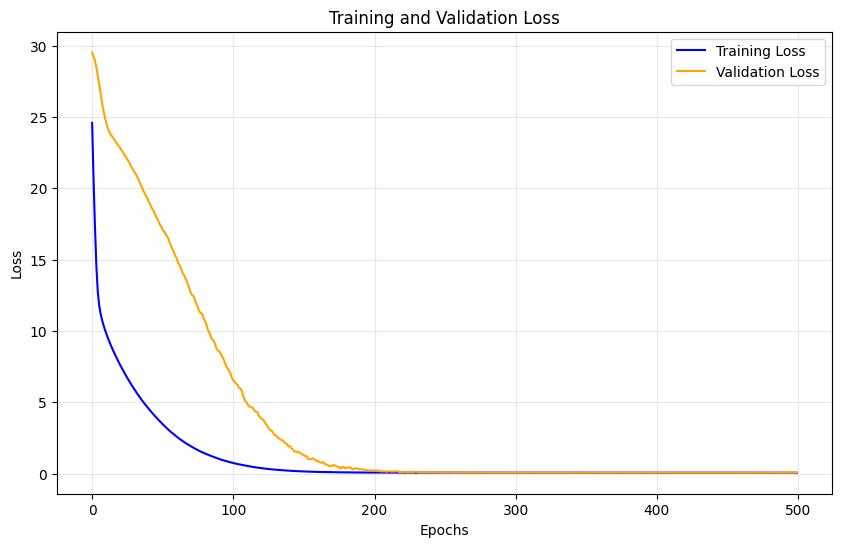

In [4]:
plot_loss(history)

In [ ]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

# Prediction & Performance

In [41]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/nitrate/modified/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/related_nitrate_2013.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2013/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*3], ctrl_data[:, 17*3]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 1s 11ms/step


In [42]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [43]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

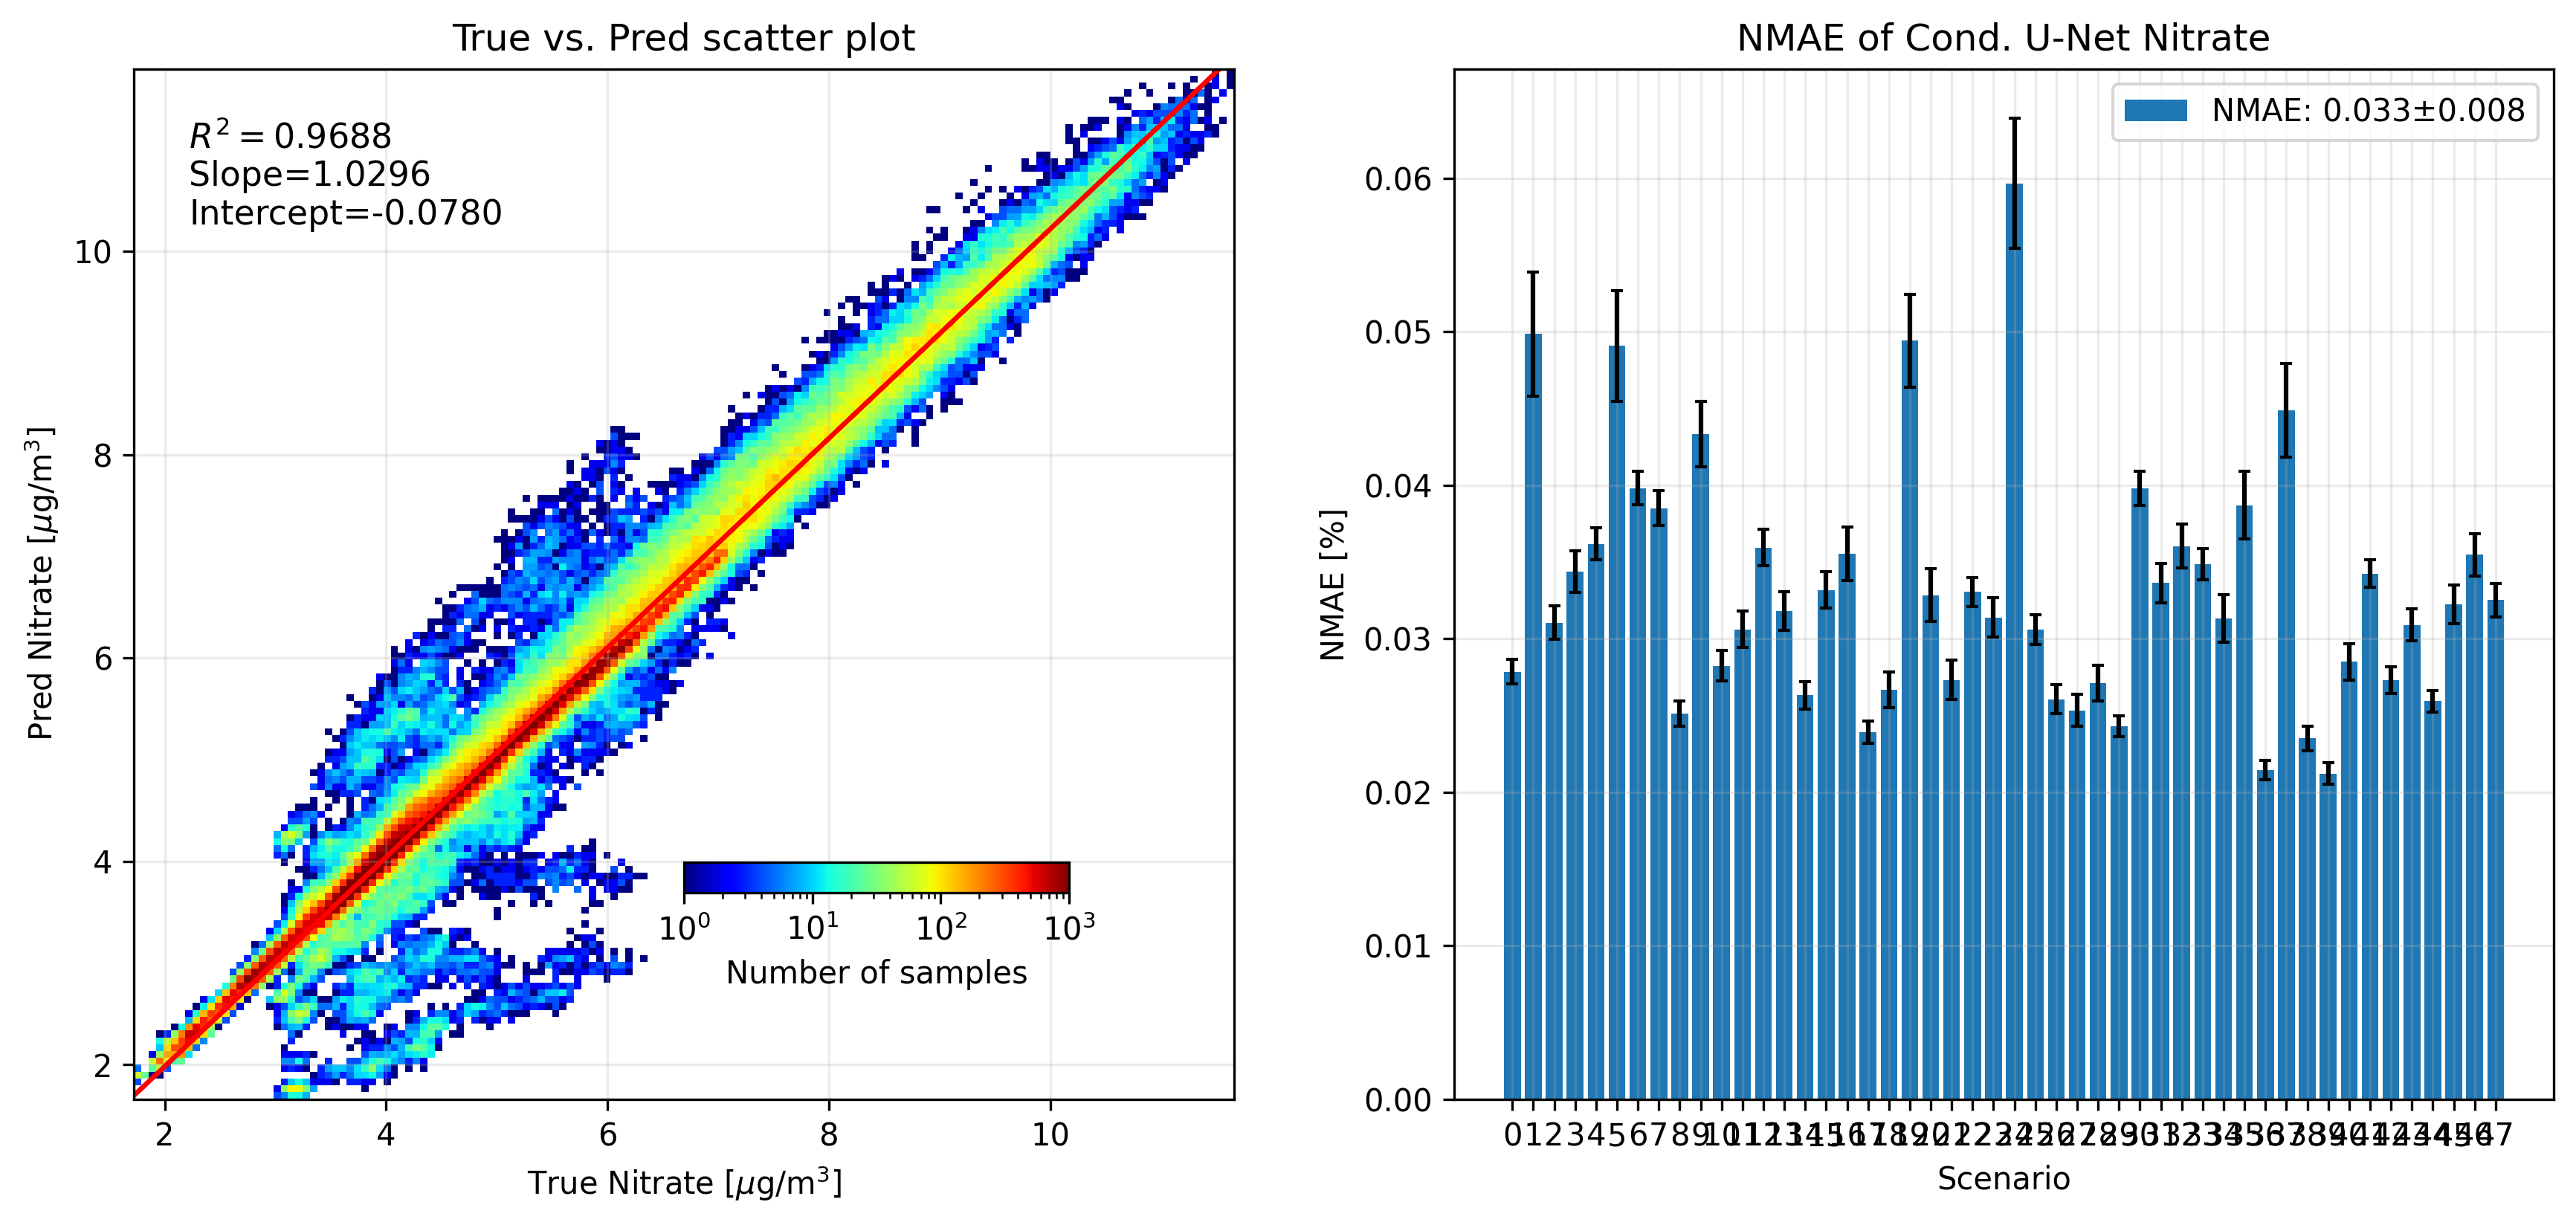

In [44]:
y_pred_ori = y_pred.reshape(-1)
y_true_ori = y_true.reshape(-1)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_ori, y_pred_ori)
axes[0].grid(alpha=0.25)
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_ori = y_test.reshape(y_test.shape[0], -1)
y_pred_ori = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Nitrate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')
plt.show()

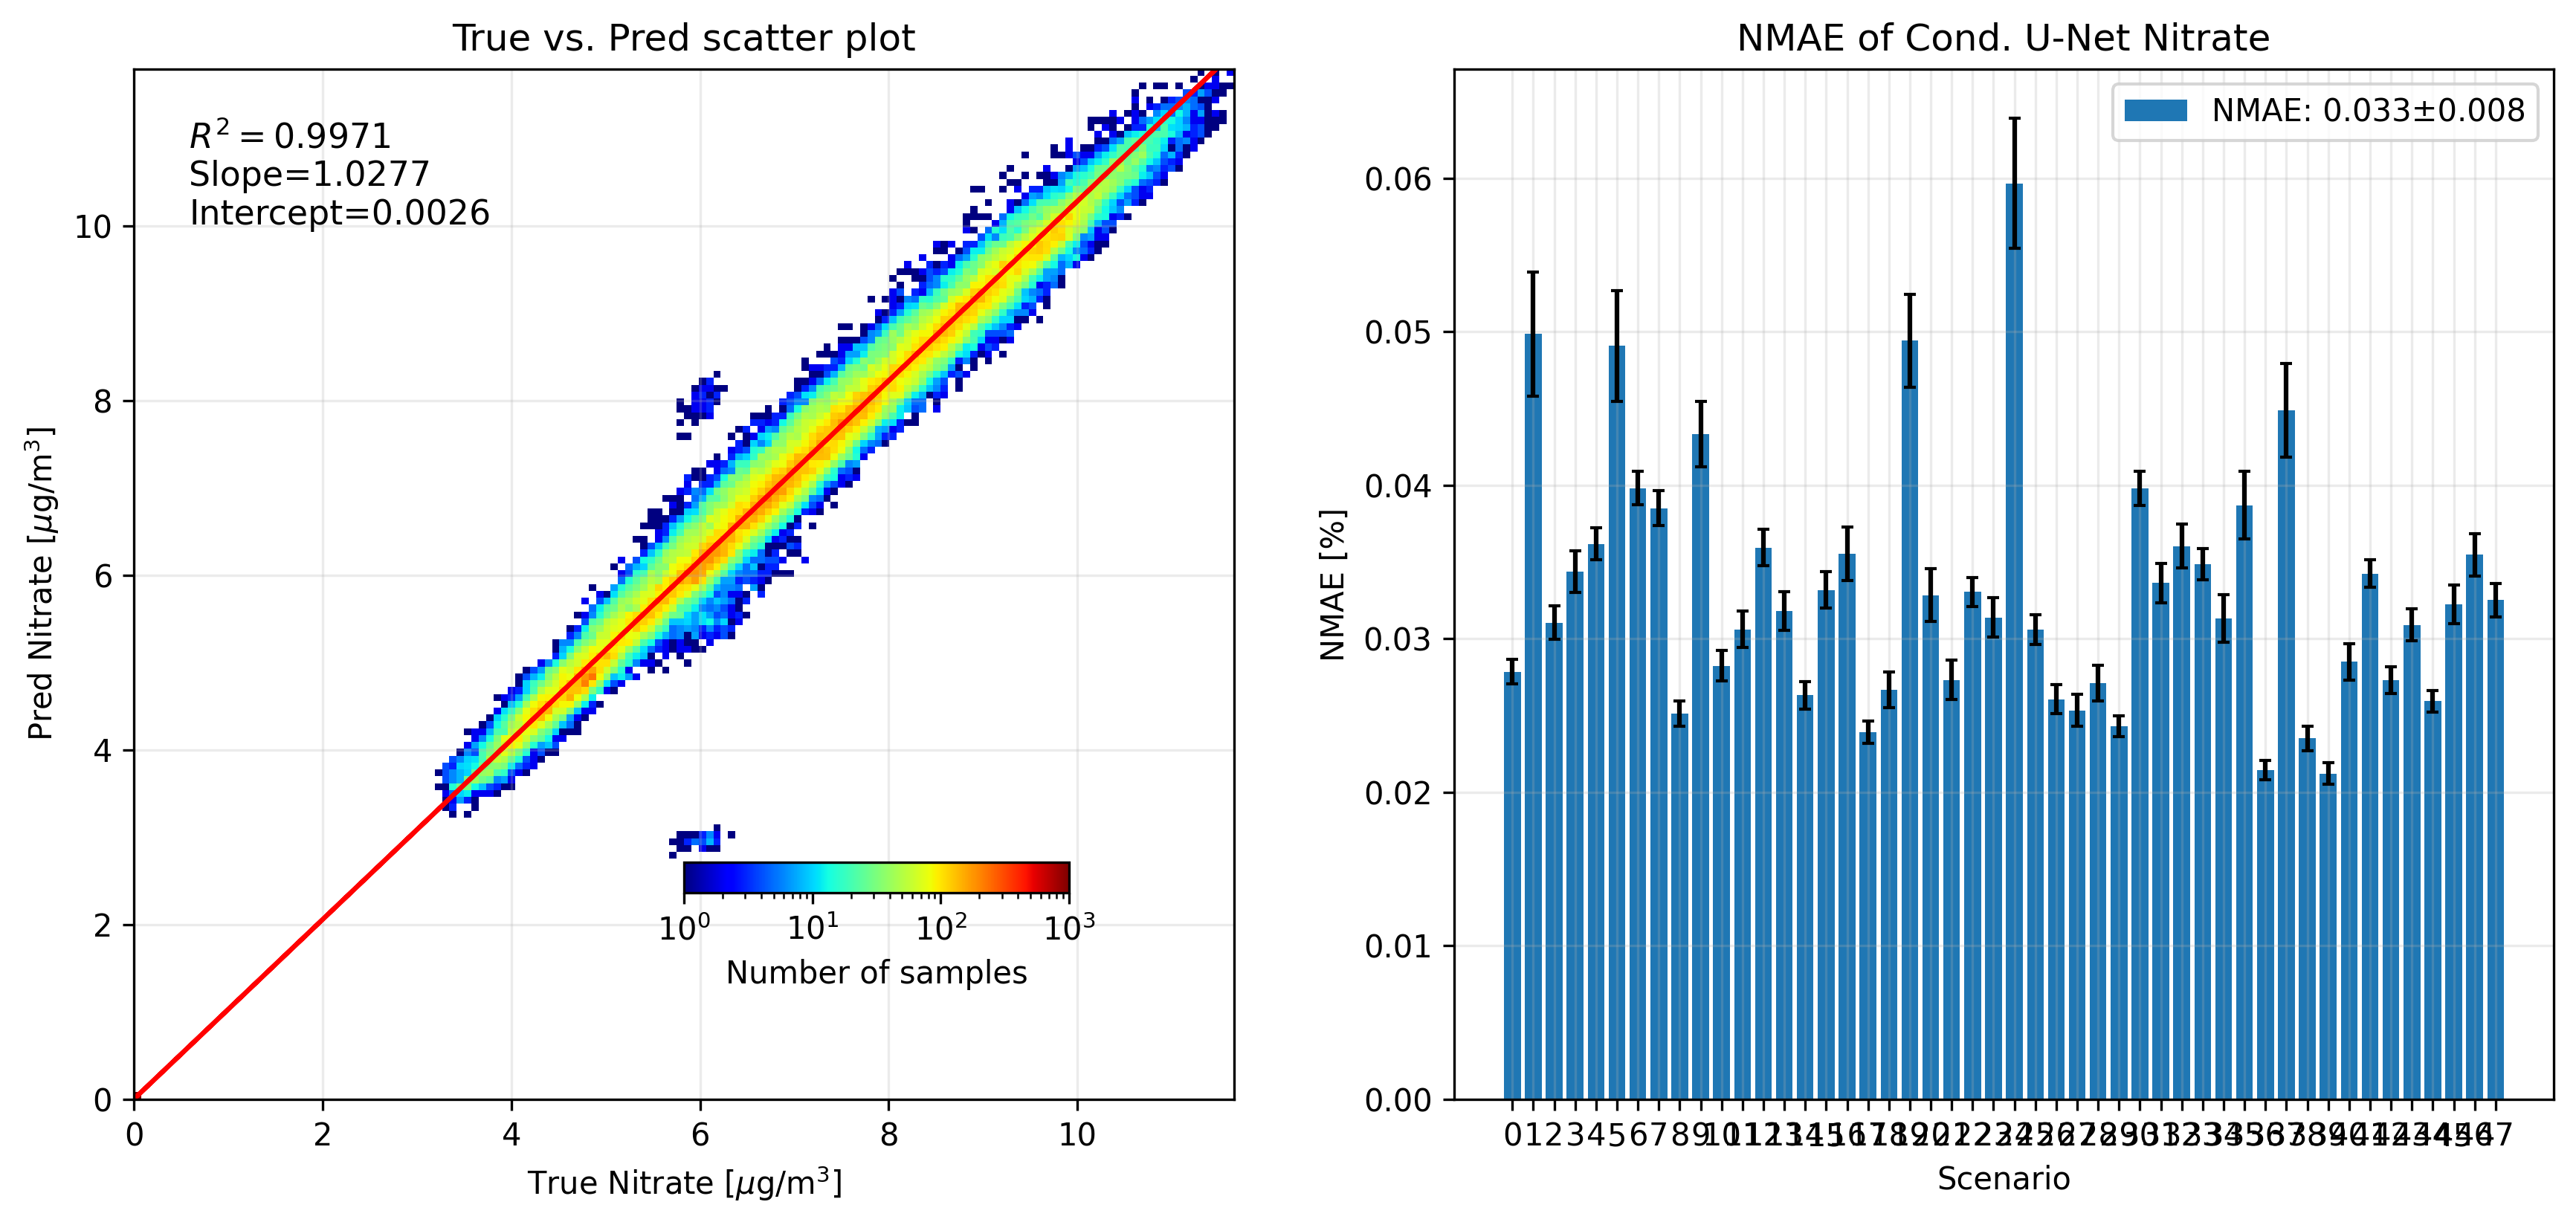

In [45]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_modi, y_pred_modi)
axes[0].grid(alpha=0.25)
# axes[0].set_xlim(3, 67)  # True 축 범위를 조정
# axes[0].set_ylim(3, 69)  # Pred 축 범위를 조정
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_modi = y_test.reshape(y_test.shape[0], -1)
y_pred_modi = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true_modi, y_pred_modi)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Nitrate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')

plt.show()

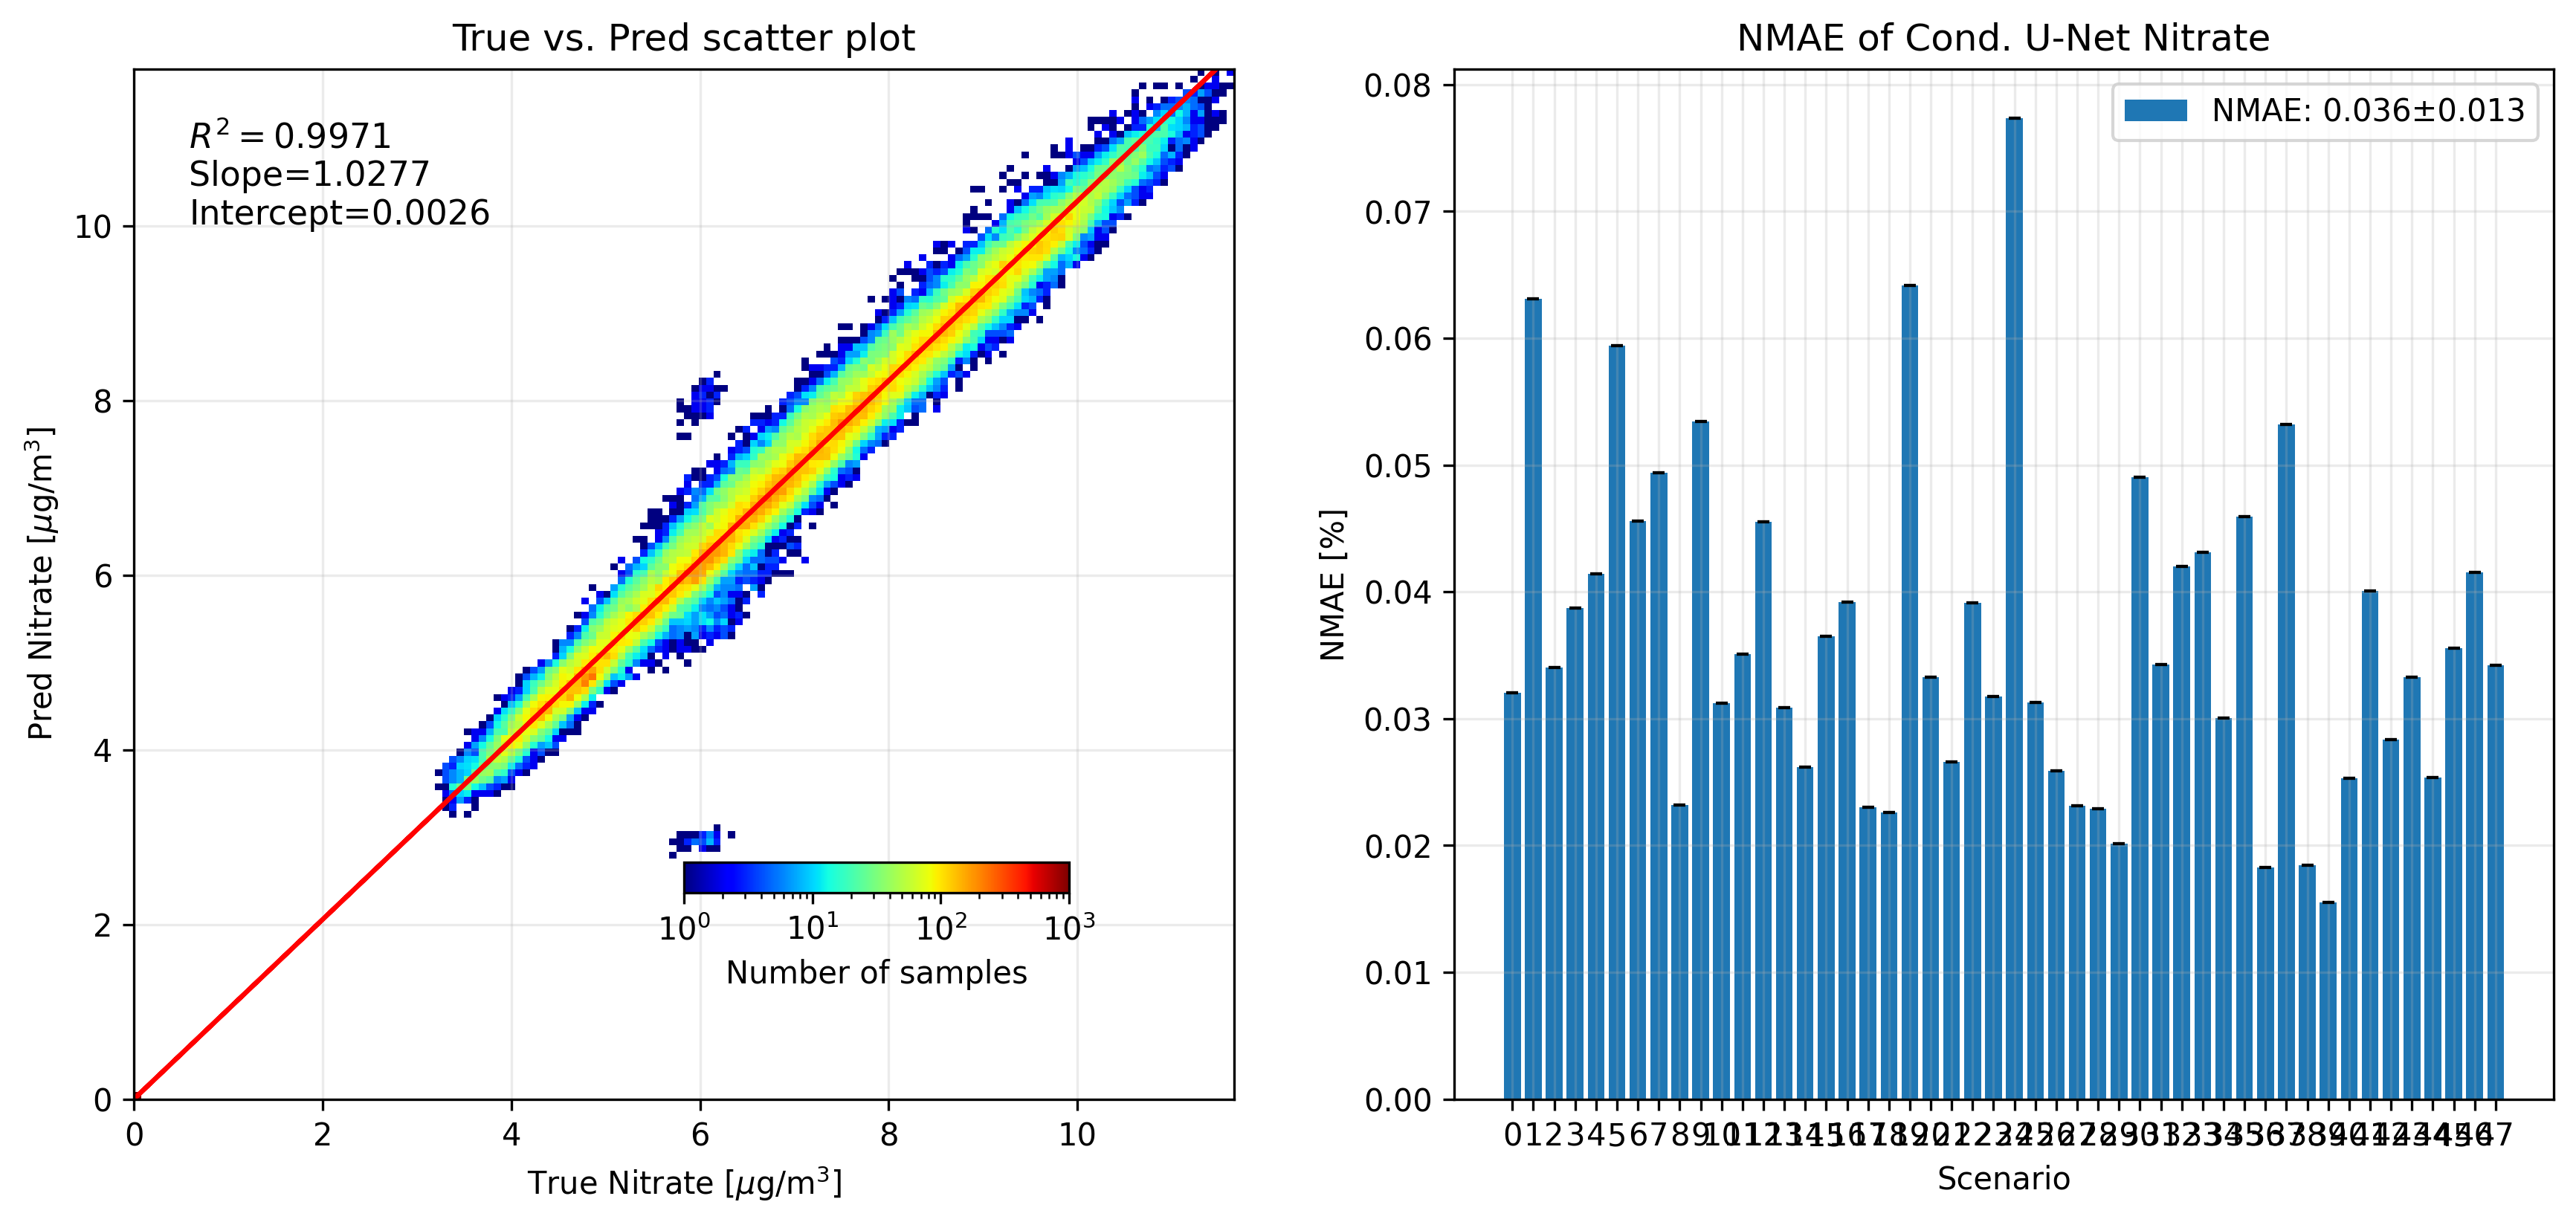

In [46]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_modi, y_pred_modi)
axes[0].grid(alpha=0.25)
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Nitrate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')

plt.show()

In [47]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


[15]


/tmp/ipykernel_2182761/3432564490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_2182761/3432564490.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_2182761/3432564490.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_2182761/3432564490.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_2182761/3432564490.py:62: UserWarning: set_ti

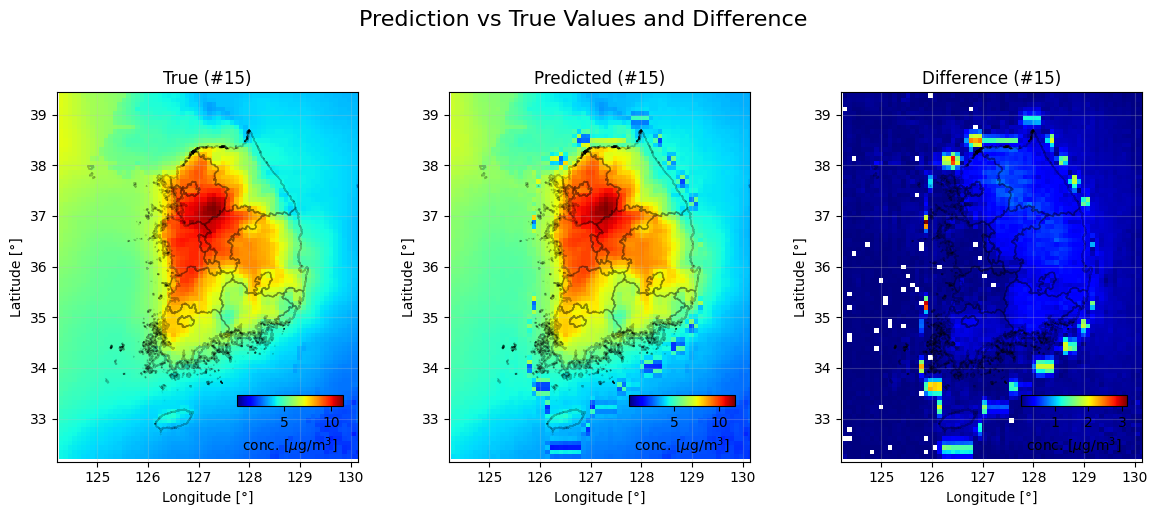

[8]


/tmp/ipykernel_2182761/3432564490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_2182761/3432564490.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_2182761/3432564490.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_2182761/3432564490.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_2182761/3432564490.py:62: UserWarning: set_ti

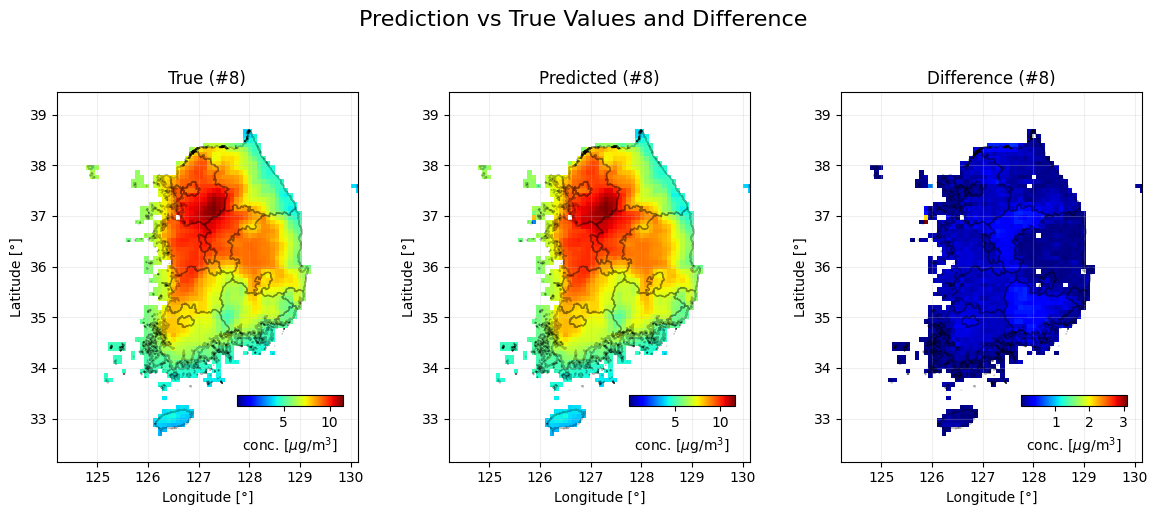

In [48]:
def plot_prediction_loss(y_true, y_pred, num_samples=1):
    indices = np.random.choice(len(y_true), num_samples, replace=False)
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(y_true, y_pred)
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines)

In [49]:
tf.keras.backend.clear_session()